In [1]:
import gym
import os
import numpy as np
import random 
from collections import namedtuple, deque 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1a) Random Agent

In [25]:
MC_env = gym.make('MountainCar-v0')
MC_env.reset()

### Exploring the env
print('State Space of the MC env : ',MC_env.observation_space)
print('Action Space of the MC env : ',MC_env.action_space)


### EXtents of the state space 
print('Low extent of MC env', MC_env.observation_space.low )
print('High extent of MC env', MC_env.observation_space.high)


State Space of the MC env :  Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Action Space of the MC env :  Discrete(3)
Low extent of MC env [-1.2  -0.07]
High extent of MC env [0.6  0.07]


In [26]:
# Initializing a random agent...

class RandAgent():
  def __init__(self,env):
    self.env = env
    pass
  def take_action(self):
    action = self.env.action_space.sample()
    return action

In [27]:
randAgent = RandAgent(MC_env)
MC_env.reset()
print(type(MC_env.state) )
done  = False
steps = 0



while not done :

  action = randAgent.take_action()
  obs, rew, done, info = MC_env.step(action)
  steps += 1
  
  print('Step {} --> action {} --> reward {} --> position {:.2f} , vel {:.2f}'.format(steps,action, rew, obs[0], obs[1]))

MC_env.close()



<class 'numpy.ndarray'>
Step 1 --> action 1 --> reward -1.0 --> position -0.49 , vel -0.00
Step 2 --> action 0 --> reward -1.0 --> position -0.49 , vel -0.00
Step 3 --> action 1 --> reward -1.0 --> position -0.49 , vel -0.00
Step 4 --> action 0 --> reward -1.0 --> position -0.49 , vel -0.00
Step 5 --> action 0 --> reward -1.0 --> position -0.50 , vel -0.00
Step 6 --> action 2 --> reward -1.0 --> position -0.50 , vel -0.00
Step 7 --> action 0 --> reward -1.0 --> position -0.51 , vel -0.00
Step 8 --> action 0 --> reward -1.0 --> position -0.51 , vel -0.01
Step 9 --> action 1 --> reward -1.0 --> position -0.52 , vel -0.01
Step 10 --> action 1 --> reward -1.0 --> position -0.52 , vel -0.01
Step 11 --> action 0 --> reward -1.0 --> position -0.53 , vel -0.01
Step 12 --> action 1 --> reward -1.0 --> position -0.54 , vel -0.01
Step 13 --> action 1 --> reward -1.0 --> position -0.54 , vel -0.01
Step 14 --> action 1 --> reward -1.0 --> position -0.55 , vel -0.01
Step 15 --> action 2 --> reward -

# Observations

1. We can observe that any action that will not lead the bot to the goal(reaching x = 0.5)--> It always gains a reward of -1. 

2. This occurs until 200 steps .

# Rendering OpenAi env in colab


In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 946 kB 7.7 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import shutil 

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video(save_dir_name):
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    print(mp4list)
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
    source = mp4list[0]
    print(source)
    dest = save_dir_name
    dest = shutil.move(source, dest)
    

  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# DQN for Mountain-Car V0


In [3]:
#### Model architecture
'''
Creating a neural net for a function approximator from state space to action space
'''
class QNet(nn.Module):

  def __init__(self, state_size, action_size, seed, fc1_size = 64, fc2_size= 64):
    '''
    state_size --> int --> Dim of each state
    action size--> int --> Dim of actions
    seed -- int -- random seed
    '''
    super(QNet, self).__init__() ### initializes the parent class i.e nn.module
    self.seed = torch.manual_seed(seed)
    self.fc1= nn.Linear(state_size,fc1_size)
    self.fc2= nn.Linear(fc1_size,fc2_size)
    self.out= nn.Linear(fc2_size, action_size)

  def forward(self, s):
    '''
    s --> state vector
    '''
    s = F.relu(self.fc1(s))
    s = F.relu(self.fc2(s))
    return self.out(s)

In [4]:
#### Replay buffer architechture...
class ReplayBuffer:
  '''
  Contains transitions represented as tuples (s,a,r,s',done)
  '''

  def __init__(self, action_size,buffer_size, batch_size, seed, device):
    '''

    '''
    self.buffer = deque(maxlen = buffer_size)
    self.action_size = action_size
    self.batch_size = batch_size
    self.seed = random.seed(seed)
    self.transition = namedtuple("Transition", field_names = ['s','a','r','ns','done'])

  def __len__(self):
    return len(self.buffer)

    
  def add(self, state, action, reward,next_state,done):
    '''
    Adds a transition tuple to the buffer
    '''
    t = self.transition(state, action, reward,next_state,done)
    self.buffer.append(t) ### Adding the transition to the buffer

  def sample(self):
    '''
    Randomly sample batch_size transitions' from the replay buffer  
    '''

    t_bs = random.sample(self.buffer, k = self.batch_size) ## transition batch size
    states = (torch.from_numpy(np.vstack([t.s for t in t_bs if t is not None])).float()).to(device)
    actions = torch.from_numpy(np.vstack([t.a for t in t_bs if t is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([t.r for t in t_bs if t is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([t.ns for t in t_bs if t is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([t.done for t in t_bs if t is not None])).float().to(device) ## converts bool to float 
    
    return (states, actions, rewards, next_states, dones)


In [17]:
##### DQN agent ...
class DQNAgent():
  '''
  Agent which generates transitions and learns
  '''
  def __init__(self, state_size, action_size, seed,device,
               BUFFER_SIZE = 100000 , #replay buffer size
               BATCH_SIZE = 128 ,        # minibatch size
               GAMMA = 0.99 ,           # discount factor
               LR = 5e-3     ,          # learning rate
               CNET_UPDATE_EVERY = 4 , # how often to update the CNet : learning
               TNET_UPDATE_EVERY = 1000  ### Steps to update target net by replacing to CNet
               ):

    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    self.BUFFER_SIZE = BUFFER_SIZE
    self.BATCH_SIZE = BATCH_SIZE
    self.GAMMA = GAMMA
    self.LR = LR
    self.CNET_UPDATE_EVERY = CNET_UPDATE_EVERY
    self.TNET_UPDATE_EVERY = TNET_UPDATE_EVERY
    self.device = device

    

    ### Init networks  CNet : current net(will learn) , TNet : Target Net (will remain same)
    self.CNet = QNet(self.state_size, self.action_size, seed, fc1_size = 32, fc2_size= 16).to(device)
    self.TNet = QNet(self.state_size, self.action_size, seed, fc1_size = 32, fc2_size= 16).to(device)
    self.optimizer = optim.Adam(self.CNet.parameters(), lr = self.LR)

    ### Init buffer 
    self.RB = ReplayBuffer(self.action_size,self.BUFFER_SIZE, self.BATCH_SIZE, seed, self.device)
    self.t_step = 0

  
  def step(self,s,a,r,ns,d):
    self.RB.add(s,a,r,ns,d)

    ## When agent to be learnt draw sample else add 
    if( (self.t_step % self.CNET_UPDATE_EVERY  == 0)  and len(self.RB) > self.BATCH_SIZE ):
      transition = self.RB.sample()
      self.learn(transition, self.GAMMA)

  def act(self, state, eps):
    '''
    Returns actions for a given state...
    '''
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device) # unsqueeze to add the batch dim
    self.CNet.eval() ## putting in inference mode

    with torch.no_grad():
      action_val = self.CNet.forward(state)

    self.CNet.train() ## putting in training mode 

    ##########################  EPS Greedy policy ############################
    if (random.random() < eps): ### eps times choose random
      return random.choice(np.arange(self.action_size))
    else: ### 1-eps times choose greedy
      return np.argmax(action_val.cpu().data.numpy()) 

  def learn(self, t_bs, gamma):

    s_bs, a_bs, r_bs, ns_bs, d_bs = t_bs  ## batch size transition values
    criterion = torch.nn.MSELoss()

    ## Set the Current Net to train mode
    self.CNet.train()
    ### Set the target Net to eval mode as no need to update target
    self.TNet.eval()

    ### get the predictions from current net --> S --> CNet(S)[a_bs] --> outputs [bs,1]
    preds = self.CNet.forward(s_bs).gather(1, a_bs) ## extract values in the action dim

    with torch.no_grad():
      ### Finding Qt(s, argmax(Qt(s,a)))
      next_state_pred = self.TNet.forward(ns_bs).detach().max(1)[0].unsqueeze(1) ## to get (bs,1)

    labels = r_bs + (gamma*next_state_pred*(1-d_bs)) ### 1-ds takes care of the terminal states..

    loss = criterion(preds, labels).to(self.device)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # ------------------- update target network ------------------- #
    #### replacing CNet with TNet after TNet_UPDATE_EVERY Steps
    if (self.t_step % self.TNET_UPDATE_EVERY == 0):
      self.hard_update(self.CNet,self.TNet)

  def hard_update(self, local_model, target_model):
    for target_param , local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(local_param.data)


  ##################  Training ##############################

  def train_agent(self,env,
                  save_dir_name, ## Name of the directory for saving results..
                  n_episodes = 1000,
                  eps_start = 1.0,eps_end = 0.01, eps_decay = 1.004,
                  TARGET_SCORE = -150, ## Min score required for saving the best model,
                  SCORE_WINDOW_LEN = 100 ,## len of the window to be averaged to visualise training curve,
                  ):
    '''
    n_epi : no. of traninin episodes
    eps_str, eps_end, eps_decay: param of eps exploration: going from random to full greedy
    TARGET_SCORE: min score required to start saving the model
    SCORE_WINDOW_LEN: len of deque storing prev episode scores.. for plotting training curve
    '''
    ##### Writing results in a txt file for further reference..
    f= open( save_dir_name + "/train_log.txt","a")
    f.write("\nHYPERPARAMETERS\n")
    comment = str(input('Enter a comment..'))
    f.write('Comment: {}\n'.format(comment) )
    f.write("\n-------------------\n")
    f.write('BUFFER_SIZE: {}\n'.format(self.BUFFER_SIZE))
    f.write('BATCH_SIZE: {}\n'.format(self.BATCH_SIZE))
    f.write('GAMMA: {}\n'.format(self.GAMMA))
    f.write('LR: {}\n'.format(self.LR))
    f.write('CNET_UPDATE_EVERY: {}\n'.format(self.CNET_UPDATE_EVERY))
    f.write('TNET_UPDATE_EVERY: {}\n'.format(self.TNET_UPDATE_EVERY))
    f.write('SEED: {}\n'.format(self.seed))


    f.write("-------------------")
    f.write("TRAIN PARAMETERS")
    f.write("-------------------\n")
    f.write('n_episodes: {}\n'.format(n_episodes))
    f.write('SCORE_WINDOW_LEN: {}\n'.format(SCORE_WINDOW_LEN))
    f.write('eps_start: {}\n'.format(eps_start))
    f.write('eps_end: {}\n'.format(eps_end))
    f.write('eps_decay(k): {}\n'.format(eps_decay))
    f.write('device: {}\n'.format(device))
    f.write('TARGET_SCORE: {}\n'.format(TARGET_SCORE))
    f.write("-------------------")
    f.write("TRAINING")
    f.write("-------------------\n")

    #####################################################################################
    ### Training ...

    scores = [] # list containing score from each episode
    scores_window = deque(maxlen=SCORE_WINDOW_LEN) # last 100 scores
    eps = eps_start
    self.t_step = 0

    ### Plotting vars
    t_steps = []
    episodes = []
    avg_scores = []

    for i_epi in range(1, n_episodes):
      state = env.reset()
      done = 0
      score = 0

      while not done: 
        self.t_step = self.t_step+1
        action = self.act(state,eps)
        next_state,reward,done,_ = env.step(action)
        self.step(state,action,reward,next_state,done)
        state = next_state
        score += reward

      scores_window.append(score) ## save the most recent score
      scores.append(score) ## sae the most recent score

      eps = max(eps/eps_decay,eps_end)## decrease the epsilon
      avg_score = np.mean(scores_window)
      print('\rEpisode {}\tAverage Score {:.2f}'.format(i_epi,avg_score), end="")

      
      if i_epi %100==0:
        print('\rEpisode {}\tAverage Score {:.2f}'.format(i_epi, avg_score ))
        f= open( save_dir_name + "/train_log.txt","a")
        f.write('\rEpisode {}\ttime_step {}\tAverage Score {:.2f}'.format(i_epi,self.t_step,avg_score))
        t_steps.append(self.t_step)
        episodes.append(i_epi)
        avg_scores.append(avg_score)
        f.close()

      if(np.mean(scores_window)>= TARGET_SCORE):
          print('\nEnvironment solve in {:d} epsiodes!\tAverage score: {:.2f}'.format(i_epi-100, avg_score ))
          TARGET_SCORE = avg_score
          torch.save(self.CNet.state_dict(),save_dir_name + '/best.pth')
          print("BEST Created!!")

    torch.save(self.CNet.state_dict(),save_dir_name +'/last.pth') 
    torch.save(self.TNet.state_dict(),save_dir_name +'/target.pth') 
    self.t_steps = t_steps
    self.avg_scores = avg_scores

    #### Plotting learning curve ...
    scaled_tsteps =  np.array(t_steps)/1e6
    plt.plot(scaled_tsteps, avg_scores)
    plt.xlabel('time steps(in millions)')
    plt.ylabel('mean-{} episode reward'.format(SCORE_WINDOW_LEN))
    plt.title('DQN Agent training')
    plt.savefig(save_dir_name + '/train_plot.png')
    
 
          

# Training

In [6]:
#### Utilities ...

def find_model_dir_title(dir_path, continue_training):
  '''
  Given a dir where all exp are stored .. finds the last dir and creates a name for the new dir
  If we want to continur training it finds the latest directory and intialises the model with last tranined models
  '''
  print('I got ',continue_training)
  dir_len = sum(os.path.isdir(dir_path +'/'+ i) for i in  os.listdir(dir_path))

  if(continue_training==1):
    dir_len = dir_len -1
  return dir_path + '/exp'+str(dir_len)

In [22]:


continue_training = int(input('continue_training..?'))

### finding save dir path...
dir_path =  '/content/drive/MyDrive/RL_implementations/Mountain_Car/DQN'
save_dir_name = find_model_dir_title(dir_path, continue_training)

if(continue_training==0):
  print('Created\t',save_dir_name )
  os.mkdir(save_dir_name)

continue_training..?0
I got  0
Created	 /content/drive/MyDrive/RL_implementations/Mountain_Car/DQN/exp19


In [23]:
### Setup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MC_env = gym.make('MountainCar-v0')

D_agent = DQNAgent( state_size = 2, action_size = 3, seed = 100,device = device,
               BUFFER_SIZE = 100000 , #replay buffer size
               BATCH_SIZE = 128 ,        # minibatch size
               GAMMA = 0.99 ,           # discount factor
               LR = 5e-3     ,          # learning rate
               CNET_UPDATE_EVERY = 5 , # how often to update the CNet : learning
               TNET_UPDATE_EVERY = 10000 ### Steps to update target net by replacing to CNet
              )


if(continue_training==1):
    print("Continue from previous model ...")
    D_agent.CNet.load_state_dict(torch.load(save_dir_name + '/last.pth'))
    D_agent.TNet.load_state_dict(torch.load(save_dir_name + '/target.pth'))


Episode 100	Average Score -200.00
Episode 200	Average Score -200.00
Episode 300	Average Score -199.05
Episode 400	Average Score -198.99
Episode 500	Average Score -198.02
Episode 600	Average Score -199.48
Episode 700	Average Score -198.59
Episode 800	Average Score -197.44
Episode 900	Average Score -197.58
Episode 1000	Average Score -196.14
Episode 1100	Average Score -196.03
Episode 1200	Average Score -195.51
Episode 1300	Average Score -196.10
Episode 1400	Average Score -195.82
Episode 1500	Average Score -195.49
Episode 1600	Average Score -196.04
Episode 1700	Average Score -196.74
Episode 1800	Average Score -192.09
Episode 1900	Average Score -193.82
Episode 2000	Average Score -194.77
Episode 2100	Average Score -190.97
Episode 2200	Average Score -192.29
Episode 2300	Average Score -189.94
Episode 2400	Average Score -190.88
Episode 2500	Average Score -182.48
Episode 2600	Average Score -186.60
Episode 2700	Average Score -185.21
Episode 2800	Average Score -181.90
Episode 2900	Average Score -1

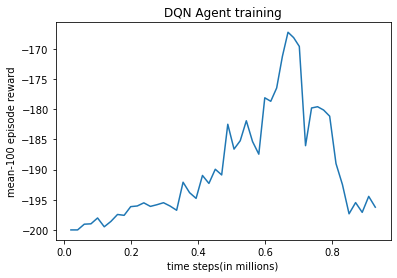

In [24]:

### Tranining starts..
D_agent.train_agent(env = MC_env,
                  save_dir_name  = save_dir_name, ## Name of the directory for saving results..
                  n_episodes = 5000,
                  eps_start = 1,eps_end = 0.01, eps_decay = 1.004,
                  TARGET_SCORE = -150, ## Min score required for saving the best model,
                  SCORE_WINDOW_LEN = 100)

# 1.b ) Learning curve for Mountain Car -V0
## Epochs trained : 1e4 episodes 
## Best mean reward achieved is : -110

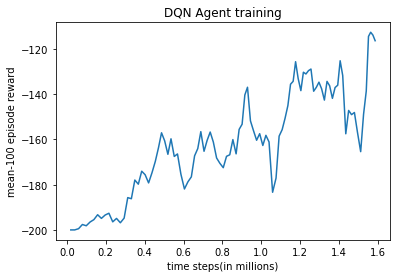

# Inference and rendering the best player

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trained_agent = DQNAgent(state_size=2,action_size=3,seed=0, device = device)
save_dir_name = '/content/drive/MyDrive/RL_implementations/Mountain_Car/DQN/exp10'
PATH = save_dir_name + '/best.pth'

trained_agent.CNet.load_state_dict(torch.load(PATH))



MC_env = wrap_env(gym.make('MountainCar-v0'))
MC_env.reset()

obs = MC_env.state
done  = False
steps = 0

while not done :
  action = trained_agent.act(obs, eps=0)
  obs, rew, done, info = MC_env.step(action)
  steps += 1

MC_env.close()
show_video(save_dir_name)


['video/openaigym.video.5.3936.video000000.mp4']


video/openaigym.video.5.3936.video000000.mp4


# 1.b ) Action graph
## Color graph representing the set of actions chosen by the trained agent.

Text(0.5, 1.0, 'Color representing :\n green--> forward, red--> back, blue--> still')

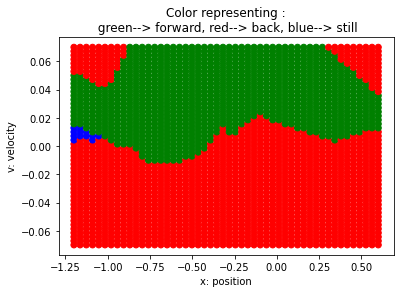

In [ ]:
MC_env = gym.make('MountainCar-v0')
x_low, v_low = MC_env.observation_space.low
x_high, v_high = MC_env.observation_space.high


vel_list = np.linspace(v_low, v_high,50)
x_list = np.linspace(x_low, x_high,50)

plot_points= []
x_plot = []
v_plot = []
a_plot = []
a_color_plot = []

for x in x_list:
  for v in vel_list:
    action = trained_agent.act(np.array([x,v], ), eps=0)

    x_plot.append(x)
    v_plot.append(v)
    a_plot.append(action)

    if(action ==0):
      a_color = 'r'
    elif(action ==1):
      a_color = 'b'
    else:
      a_color = 'g'
    a_color_plot.append(a_color)

plt.scatter(x_plot,v_plot, color = a_color_plot)
plt.xlabel('x: position')
plt.ylabel('v: velocity')
plt.title("Color representing :\n green--> forward, red--> back, blue--> still")
    



# 1.c) Hyper parameter tuning ..
## Chosen hyper param : exploration scheduling 
### Varied eps_start, eps_end, eps_decay (k)


In [ ]:
'''
Parameters 
-------------------
BUFFER_SIZE: 100000
BATCH_SIZE: 128
GAMMA: 0.99
LR: 0.005
CNET_UPDATE_EVERY: 5
TNET_UPDATE_EVERY: 10000
SEED: None
-------------------TRAIN PARAMETERS-------------------
n_episodes: 10000
SCORE_WINDOW_LEN: 100
eps_start: 1
eps_end: 0.01
eps_decay(k): 1.004
device: cuda:0
TARGET_SCORE: -150
'''

# Exploration schedule : starts with random and then progresses for greedy exploration .


eps_start : 1 

eps_end : 0.01

eps_decay (k) : 1.004

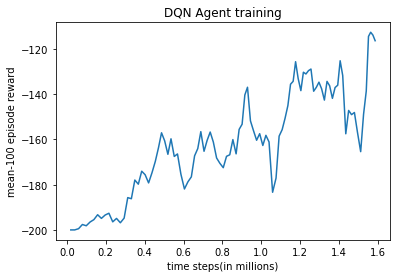

# Exploration schedule : starts with greedy and then progresses for random exploration .

eps_start : 0.01

eps_end : 0.9

eps_decay (k) : 0.996

## Observed no training 



In [ ]:
'''
Parameters 
-------------------
BUFFER_SIZE: 100000
BATCH_SIZE: 128
GAMMA: 0.99
LR: 0.005
CNET_UPDATE_EVERY: 5
TNET_UPDATE_EVERY: 10000
SEED: None
-------------------TRAIN PARAMETERS-------------------
n_episodes: 5000
SCORE_WINDOW_LEN: 100
eps_start: 0.01
eps_end: 0.9
eps_decay(k): 0.996
device: cuda:0
TARGET_SCORE: -150
'''

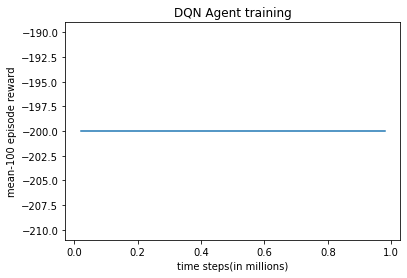

# Exploration schedule : constant random exploration

eps_start : 0.9

eps_end : 0.9

eps_decay (k) : 1

## Observed no training 



In [ ]:
'''
HYPERPARAMETERS
Comment: const random exploration

-------------------
BUFFER_SIZE: 100000
BATCH_SIZE: 128
GAMMA: 0.99
LR: 0.005
CNET_UPDATE_EVERY: 5
TNET_UPDATE_EVERY: 10000
SEED: None
-------------------TRAIN PARAMETERS-------------------
n_episodes: 5000
SCORE_WINDOW_LEN: 100
eps_start: 0.9
eps_end: 0.9
eps_decay(k): 1
device: cuda:0
TARGET_SCORE: -150
'''

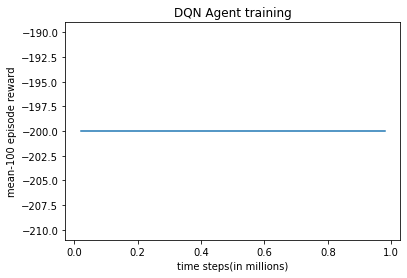

# Exploration schedule : constant greedy exploration

eps_start : 0.1

eps_end : 0.1

eps_decay (k) : 1

## Observed no training 



In [ ]:
'''
HYPERPARAMETERS
Comment: greedy exploration

-------------------
BUFFER_SIZE: 100000
BATCH_SIZE: 128
GAMMA: 0.99
LR: 0.005
CNET_UPDATE_EVERY: 5
TNET_UPDATE_EVERY: 10000
SEED: None
-------------------TRAIN PARAMETERS-------------------
n_episodes: 5000
SCORE_WINDOW_LEN: 100
eps_start: 0.1
eps_end: 0.1
eps_decay(k): 1
device: cuda:0
TARGET_SCORE: -150
'''

'\nHYPERPARAMETERS\nComment: greedy exploration\n\n-------------------\nBUFFER_SIZE: 100000\nBATCH_SIZE: 128\nGAMMA: 0.99\nLR: 0.005\nCNET_UPDATE_EVERY: 5\nTNET_UPDATE_EVERY: 10000\nSEED: None\n-------------------TRAIN PARAMETERS-------------------\nn_episodes: 5000\nSCORE_WINDOW_LEN: 100\neps_start: 0.1\neps_end: 0.1\neps_decay(k): 1\ndevice: cuda:0\nTARGET_SCORE: -150\n'

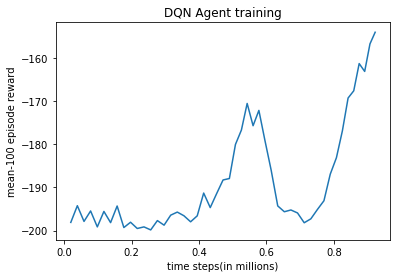

# DDQN : code for training

In [11]:
class DoubleDQNAgent(DQNAgent):
  def __init__(self, state_size, action_size, seed,device,
               BUFFER_SIZE = 100000 , #replay buffer size
               BATCH_SIZE = 128 ,        # minibatch size
               GAMMA = 0.99 ,           # discount factor
               LR = 5e-3     ,          # learning rate
               CNET_UPDATE_EVERY = 4 , # how often to update the CNet : learning
               TNET_UPDATE_EVERY = 1000  ### Steps to update target net by replacing to CNet
               ):
    super(DoubleDQNAgent, self).__init__(state_size, action_size, seed,device,BUFFER_SIZE,BATCH_SIZE ,GAMMA,LR,CNET_UPDATE_EVERY,TNET_UPDATE_EVERY )

  def learn(self, t_bs, gamma):
    
    
    s_bs, a_bs, r_bs, ns_bs, d_bs = t_bs  ## batch size transition values
    criterion = torch.nn.MSELoss()

    ## Set the Current Net to train mode
    self.CNet.train()
    ### Set the target Net to eval mode as no need to update target
    self.TNet.eval()

    ### get the predictions from current net --> S --> CNet(S)[a_bs] --> outputs [bs,1]
    preds = self.CNet.forward(s_bs).gather(1, a_bs) ## extract values in the action dim



    ##############  The only change for Double DQN #####################
    '''
    #next_state_Q = Q_TNET(s, argmax(Q_CNET))
    '''

    self.CNet.eval()
    with torch.no_grad():
      actions_CNET = self.CNet.forward(ns_bs).detach().max(1)[1].unsqueeze(1).long() ## gets argmax due to [1]
      next_state_pred = self.TNet.forward(ns_bs).gather(1, actions_CNET) ## to get (bs,1)


    #######################################################################

    labels = r_bs + (gamma*next_state_pred*(1-d_bs)) ### 1-ds takes care of the terminal states..

    loss = criterion(preds, labels).to(self.device)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # ------------------- update target network ------------------- #
    #### replacing CNet with TNet after TNet_UPDATE_EVERY Steps
    if (self.t_step % self.TNET_UPDATE_EVERY == 0):
      self.hard_update(self.CNet,self.TNet)


  ##################  Training ##############################

  def train_agent(self,env,
                  save_dir_name, ## Name of the directory for saving results..
                  n_episodes = 1000,
                  eps_start = 1.0,eps_end = 0.01, eps_decay = 1.004,
                  TARGET_SCORE = -150, ## Min score required for saving the best model,
                  SCORE_WINDOW_LEN = 100 ,## len of the window to be averaged to visualise training curve,
                  ):
      '''
      n_epi : no. of traninin episodes
      eps_str, eps_end, eps_decay: param of eps exploration: going from random to full greedy
      TARGET_SCORE: min score required to start saving the model
      SCORE_WINDOW_LEN: len of deque storing prev episode scores.. for plotting training curve
      '''
      ##### Writing results in a txt file for further reference..
      f= open( save_dir_name + "/train_log.txt","a")
      f.write("\nHYPERPARAMETERS\n")
      comment = str(input('Enter a comment..'))
      f.write('Comment: {}\n'.format(comment) )
      f.write("\n-------------------\n")
      f.write('BUFFER_SIZE: {}\n'.format(self.BUFFER_SIZE))
      f.write('BATCH_SIZE: {}\n'.format(self.BATCH_SIZE))
      f.write('GAMMA: {}\n'.format(self.GAMMA))
      f.write('LR: {}\n'.format(self.LR))
      f.write('CNET_UPDATE_EVERY: {}\n'.format(self.CNET_UPDATE_EVERY))
      f.write('TNET_UPDATE_EVERY: {}\n'.format(self.TNET_UPDATE_EVERY))
      f.write('SEED: {}\n'.format(self.seed))


      f.write("-------------------")
      f.write("TRAIN PARAMETERS")
      f.write("-------------------\n")
      f.write('n_episodes: {}\n'.format(n_episodes))
      f.write('SCORE_WINDOW_LEN: {}\n'.format(SCORE_WINDOW_LEN))
      f.write('eps_start: {}\n'.format(eps_start))
      f.write('eps_end: {}\n'.format(eps_end))
      f.write('eps_decay(k): {}\n'.format(eps_decay))
      f.write('device: {}\n'.format(device))
      f.write('TARGET_SCORE: {}\n'.format(TARGET_SCORE))
      f.write("-------------------")
      f.write("TRAINING")
      f.write("-------------------\n")

      #####################################################################################
      ### Training ...

      scores = [] # list containing score from each episode
      scores_window = deque(maxlen=SCORE_WINDOW_LEN) # last 100 scores
      eps = eps_start
      self.t_step = 0

      ### Plotting vars
      t_steps = []
      episodes = []
      avg_scores = []

      for i_epi in range(1, n_episodes):
        state = env.reset()
        done = 0
        score = 0

        while not done: 
          self.t_step = self.t_step+1
          action = self.act(state,eps)
          next_state,reward,done,_ = env.step(action)
          self.step(state,action,reward,next_state,done)
          state = next_state
          score += reward

        scores_window.append(score) ## save the most recent score
        scores.append(score) ## sae the most recent score

        eps = max(eps/eps_decay,eps_end)## decrease the epsilon
        avg_score = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score {:.2f}'.format(i_epi,avg_score), end="")

        
        if i_epi %100==0:
          print('\rEpisode {}\tAverage Score {:.2f}'.format(i_epi, avg_score ))
          f= open( save_dir_name + "/train_log.txt","a")
          f.write('\rEpisode {}\ttime_step {}\tAverage Score {:.2f}'.format(i_epi,self.t_step,avg_score))
          t_steps.append(self.t_step)
          episodes.append(i_epi)
          avg_scores.append(avg_score)
          f.close()

        if(np.mean(scores_window)>= TARGET_SCORE):
            print('\nEnvironment solve in {:d} epsiodes!\tAverage score: {:.2f}'.format(i_epi-100, avg_score ))
            TARGET_SCORE = avg_score
            torch.save(self.CNet.state_dict(),save_dir_name + '/best.pth')
            print("BEST Created!!")

      torch.save(self.CNet.state_dict(),save_dir_name +'/last.pth') 
      torch.save(self.TNet.state_dict(),save_dir_name +'/target.pth') 
      self.t_steps = t_steps
      self.avg_scores = avg_scores

      #### Plotting learning curve ...
      scaled_tsteps =  np.array(t_steps)/1e6
      plt.plot(scaled_tsteps, avg_scores)
      plt.xlabel('time steps(in millions)')
      plt.ylabel('mean-{} episode reward'.format(SCORE_WINDOW_LEN))
      plt.title('DDQN Agent training')
      plt.savefig(save_dir_name + '/train_plot.png')
      
    
      

continue_training..?0
I got  0
Created	 /content/drive/MyDrive/RL_implementations/Mountain_Car/DDQN/exp6
Enter a comment..training at seed 100 -- for 5000 epochs
Episode 100	Average Score -200.00
Episode 200	Average Score -200.00
Episode 300	Average Score -200.00
Episode 400	Average Score -199.68
Episode 500	Average Score -199.97
Episode 600	Average Score -199.84
Episode 700	Average Score -198.81
Episode 800	Average Score -196.88
Episode 900	Average Score -199.50
Episode 1000	Average Score -199.59
Episode 1100	Average Score -199.68
Episode 1200	Average Score -199.56
Episode 1300	Average Score -199.43
Episode 1400	Average Score -199.80
Episode 1500	Average Score -197.71
Episode 1600	Average Score -199.03
Episode 1700	Average Score -199.99
Episode 1800	Average Score -196.64
Episode 1900	Average Score -198.43
Episode 2000	Average Score -198.26
Episode 2100	Average Score -195.97
Episode 2200	Average Score -197.50
Episode 2300	Average Score -193.02
Episode 2400	Average Score -192.89
Episode

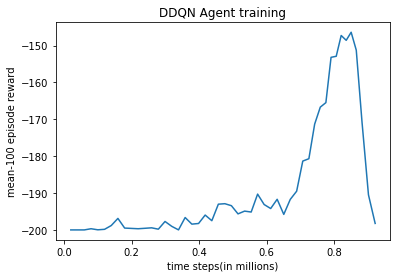

In [16]:


continue_training = int(input('continue_training..?'))

### finding save dir path...
dir_path =  '/content/drive/MyDrive/RL_implementations/Mountain_Car/DDQN'
save_dir_name = find_model_dir_title(dir_path, continue_training)

if(continue_training==0):
  print('Created\t',save_dir_name )
  os.mkdir(save_dir_name)


### Setup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MC_env = gym.make('MountainCar-v0')

Double_agent = DoubleDQNAgent( state_size = 2, action_size = 3, seed = 100,device = device,
               BUFFER_SIZE = 100000 , #replay buffer size
               BATCH_SIZE = 128 ,        # minibatch size
               GAMMA = 0.99 ,           # discount factor
               LR = 5e-3     ,          # learning rate
               CNET_UPDATE_EVERY = 5 , # how often to update the CNet : learning
               TNET_UPDATE_EVERY = 10000 ### Steps to update target net by replacing to CNet
              )


if(continue_training==1):
    print("Continue from previous model ...")
    Double_agent.CNet.load_state_dict(torch.load(save_dir_name + '/last.pth'))
    Double_agent.TNet.load_state_dict(torch.load(save_dir_name + '/target.pth'))


### Tranining starts..
Double_agent.train_agent(env = MC_env,
                  save_dir_name  = save_dir_name, ## Name of the directory for saving results..
                  n_episodes = 5000,
                  eps_start = 1.0,eps_end = 0.01, eps_decay = 1.004,
                  TARGET_SCORE = -150, ## Min score required for saving the best model,
                  SCORE_WINDOW_LEN = 100)

#1d) DQN vs DDQN
Runnning with different random seeds with similar parameters as follows 




# >> For random seed 0


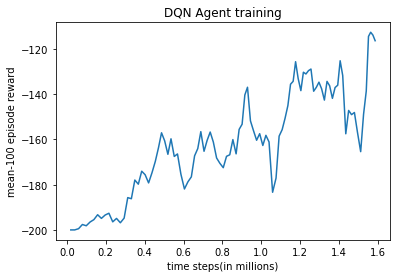

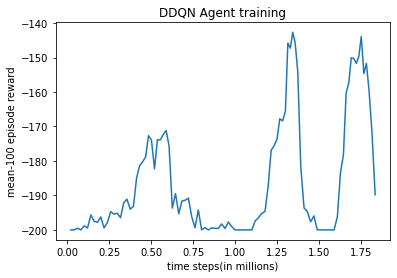

# >> For Random seed 10

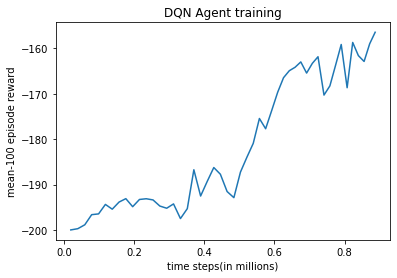

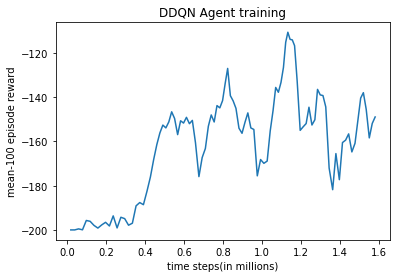

# >> For Random seed 100

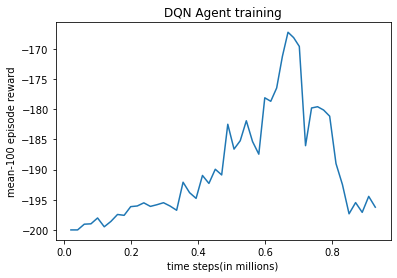

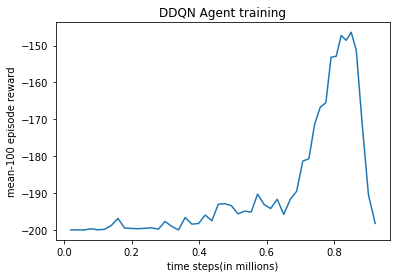

Observations : DDQN trains faster than DQN

# THE END